# **[HuBMAP 2023] K-fold CV COCO Dataset Generator**

### Versions
* V6 - 1 Category:  **{1: 'blood_vessel'}**
* V5 - Ignore it ,I made mistake!!!
* V4 - 3 Categories:**{1: 'glomerulus', 2: 'blood_vessel', 3: 'unsure'}**

In [1]:
# !pip install pycocotools -Uqq

### importing libraries

In [55]:
import json, cv2, numpy as np, itertools, random, pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection

import matplotlib.pyplot as plt
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as mpatches


### Functions

In [56]:
def coordinates_to_masks(coordinates, shape):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(coord)], 1)
        masks.append(mask)
    return masks

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def rle_to_binary_mask(mask_rle, shape=(1024, 1024)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

### Loading Dataset

In [57]:
df = pd.read_csv('/home/nischay/hubmap/Data/tile_meta.csv')
df2 = df.query('dataset == 2')#.query('source_wsi <= 2')

df = df.query('dataset == 1')
#df=df.head(500)
df.reset_index(inplace=True,drop=True)
df.head()

,id,source_wsi,dataset,i,j
0,0033bbc76b6b,1,1,10240,43008
1,00656c6f2690,1,1,10240,46080
2,0067d5ad2250,2,1,23552,22528
3,00d75ad65de3,1,1,8192,39424
4,00da70813521,1,1,10240,46592


In [58]:
df[df['dataset']==1].source_wsi.value_counts()

source_wsi
1    270
2    152
Name: count, dtype: int64

In [59]:
df2[df2['dataset']==2].source_wsi.value_counts()


source_wsi
3    410
2    293
4    271
1    237
Name: count, dtype: int64

In [60]:
237+270

507

In [61]:
293+152

445

In [62]:
(182*410) / (410+271)

109.5741556534508

### Spliting training & Valid

In [63]:
from sklearn.model_selection import StratifiedKFold

n_splits=5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['source_wsi']), 1):
    df.loc[val_idx, 'fold'] = fold
    
df['fold'] = df['fold'].astype(np.uint8)
df.groupby('fold').size()

fold
1    85
2    85
3    84
4    84
5    84
dtype: int64

In [64]:
df2['fold'] = -1
df = pd.concat([df,df2[df2['source_wsi'].isin([3,4])]],axis=0).reset_index(drop=True)

In [65]:
df.groupby('fold').size()

fold
-1    681
 1     85
 2     85
 3     84
 4     84
 5     84
dtype: int64

In [66]:
df

,id,source_wsi,dataset,i,j,fold
0,0033bbc76b6b,1,1,10240,43008,1
1,00656c6f2690,1,1,10240,46080,3
2,0067d5ad2250,2,1,23552,22528,4
3,00d75ad65de3,1,1,8192,39424,2
4,00da70813521,1,1,10240,46592,3
...,...,...,...,...,...,...
1098,ff434af74304,4,2,3072,22528,-1
1099,ff4897b3eda6,4,2,11776,20992,-1
1100,ff66dec71c4c,3,2,5120,10752,-1
1101,ff99cdef0f2a,4,2,5120,24064,-1


In [67]:
selected_fold=1
# train_ids = df.query(f'fold == -1')['id'].values.tolist()

train_ids = df.query(f'fold != {selected_fold}')['id'].values.tolist()
valid_ids = df.query(f'fold == {selected_fold}')['id'].values.tolist()

# train_ids = train_ids + valid_ids
print(len(train_ids), len(valid_ids))

1018 85


### Reading polygons.jsonl

In [68]:
jsonl_file_path = "/home/nischay/hubmap/Data/polygons.jsonl"
data = []
with open(jsonl_file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

In [69]:
# data[0] #['annotations'][0]['type']

In [70]:
from tqdm import tqdm
tqdm.pandas()

In [71]:
count_glo = 0
for i in tqdm(range(len(data))):
    id = data[i]['annotations']
    if data[i]['id'] in df2[df2['source_wsi']==4].id.to_list():
        
        count = 0
        for j in range(len(id)):
            if id[j]['type'] == 'glomerulus':
                count +=1
        if count >0:
            count_glo += 1

100%|█████████████████████████████████████| 1633/1633 [00:00<00:00, 5310.47it/s]


In [72]:
count_glo

81

### Categories

In [75]:
categories_list=['blood_vessel']
#------------------------------------------------------------------------------
categories_ids = {name:id for id, name in enumerate(categories_list)}  
ids_categories = {id:name for id, name in enumerate(categories_list)}  
categories =[{'id':id,'name':name} for name,id in categories_ids.items()]

print(categories_ids)
print(ids_categories)
print(categories)

{'blood_vessel': 0}
{0: 'blood_vessel'}
[{'id': 0, 'name': 'blood_vessel'}]


In [76]:
# train_ids


### Creating COCO

In [77]:
def coco_structure(images_ids):
    idx=1
    annotations=[]
    images=[]
    for item in tqdm(data,total=int(len(images_ids))):
        image_id=item["id"]
        if image_id in images_ids:
            image = {"id": image_id, "file_name": image_id + ".tif", "height": 512, "width": 512}
            images.append(image)
        else:continue
        #-----------------------------
        anns=item["annotations"]
        for an in anns:
            category_type=an["type"]
            if category_type =="blood_vessel":
                category_id=categories_ids[category_type]
                segmentation=an["coordinates"]
                mask_img = coordinates_to_masks(segmentation, (512, 512))[0]
                ys, xs = np.where(mask_img)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)

                rle = binary_mask_to_rle(mask_img)

                seg = {
                    "id": idx,
                    "image_id": image_id,
                    "category_id": category_id,
                    "segmentation": rle,
                    "bbox": [int(x1), int(y1), int(x2 - x1 + 1), int(y2 - y1 + 1)],
                    "area": int(np.sum(mask_img)),
                    "iscrowd": 0,
                }
                if image_id in images_ids:
                    annotations.append(seg)
                    idx=idx+1
                
    return {"info": {}, "licenses": [], "categories": categories, "images": images, "annotations": annotations}

In [78]:
train_coco_data = coco_structure(train_ids)
valid_coco_data = coco_structure(valid_ids)

1633it [02:19, 11.72it/s]                                                       
1633it [00:09, 166.55it/s]                                                      


In [79]:
import timm


In [83]:
len(train_ids)

1018

In [80]:
# a

In [81]:
2048//(6/4)

1365.0

In [52]:
# df.to_csv('coco/folds5.csv',index=False)

In [84]:
output_file_path = f"cocov2/ds1allds2wsi34_coco_1024_train_all_fold{selected_fold}.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(train_coco_data, output_file, ensure_ascii=True, indent=4)
    
output_file_path = f"cocov2/ds1allds2wsi34_coco_1024_valid_all_fold{selected_fold}.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(valid_coco_data, output_file, ensure_ascii=True, indent=4)

### Saving COCO

In [19]:
# output_file_path = f"coco/ds12_coco_1024_train_fold{selected_fold}.json"
# with open(output_file_path, "w", encoding="utf-8") as output_file:
#     json.dump(train_coco_data, output_file, ensure_ascii=True, indent=4)
    
# output_file_path = f"coco/ds12_coco_1024_valid_fold{selected_fold}.json"
# with open(output_file_path, "w", encoding="utf-8") as output_file:
#     json.dump(valid_coco_data, output_file, ensure_ascii=True, indent=4)

In [21]:
len(train_coco_data['images'])

1211

In [24]:
df2.source_wsi.value_counts()

source_wsi
3    410
2    293
4    271
1    237
Name: count, dtype: int64

In [21]:
# !pip install imagecodecs
valid_coco_data['images'][2]


{'id': '0788fc3be62e',
 'file_name': '0788fc3be62e.tif',
 'height': 512,
 'width': 512}

In [22]:
valid_coco_data['annotations'][2]


{'id': 3,
 'image_id': '0033bbc76b6b',
 'category_id': 0,
 'segmentation': {'counts': [190975,
   1,
   508,
   4,
   506,
   6,
   505,
   7,
   504,
   8,
   503,
   9,
   502,
   10,
   502,
   10,
   501,
   11,
   501,
   11,
   501,
   11,
   500,
   12,
   499,
   13,
   499,
   13,
   498,
   14,
   497,
   15,
   497,
   15,
   496,
   16,
   496,
   16,
   496,
   16,
   497,
   15,
   497,
   15,
   498,
   14,
   499,
   13,
   499,
   13,
   499,
   13,
   499,
   13,
   500,
   12,
   500,
   12,
   501,
   11,
   501,
   11,
   502,
   10,
   502,
   10,
   503,
   9,
   504,
   8,
   506,
   6,
   53248],
  'size': [512, 512]},
 'bbox': [372, 496, 36, 16],
 'area': 403,
 'iscrowd': 0}

In [23]:
valid_coco_data['categories']

[{'id': 0, 'name': 'blood_vessel'}]

### Visualization

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


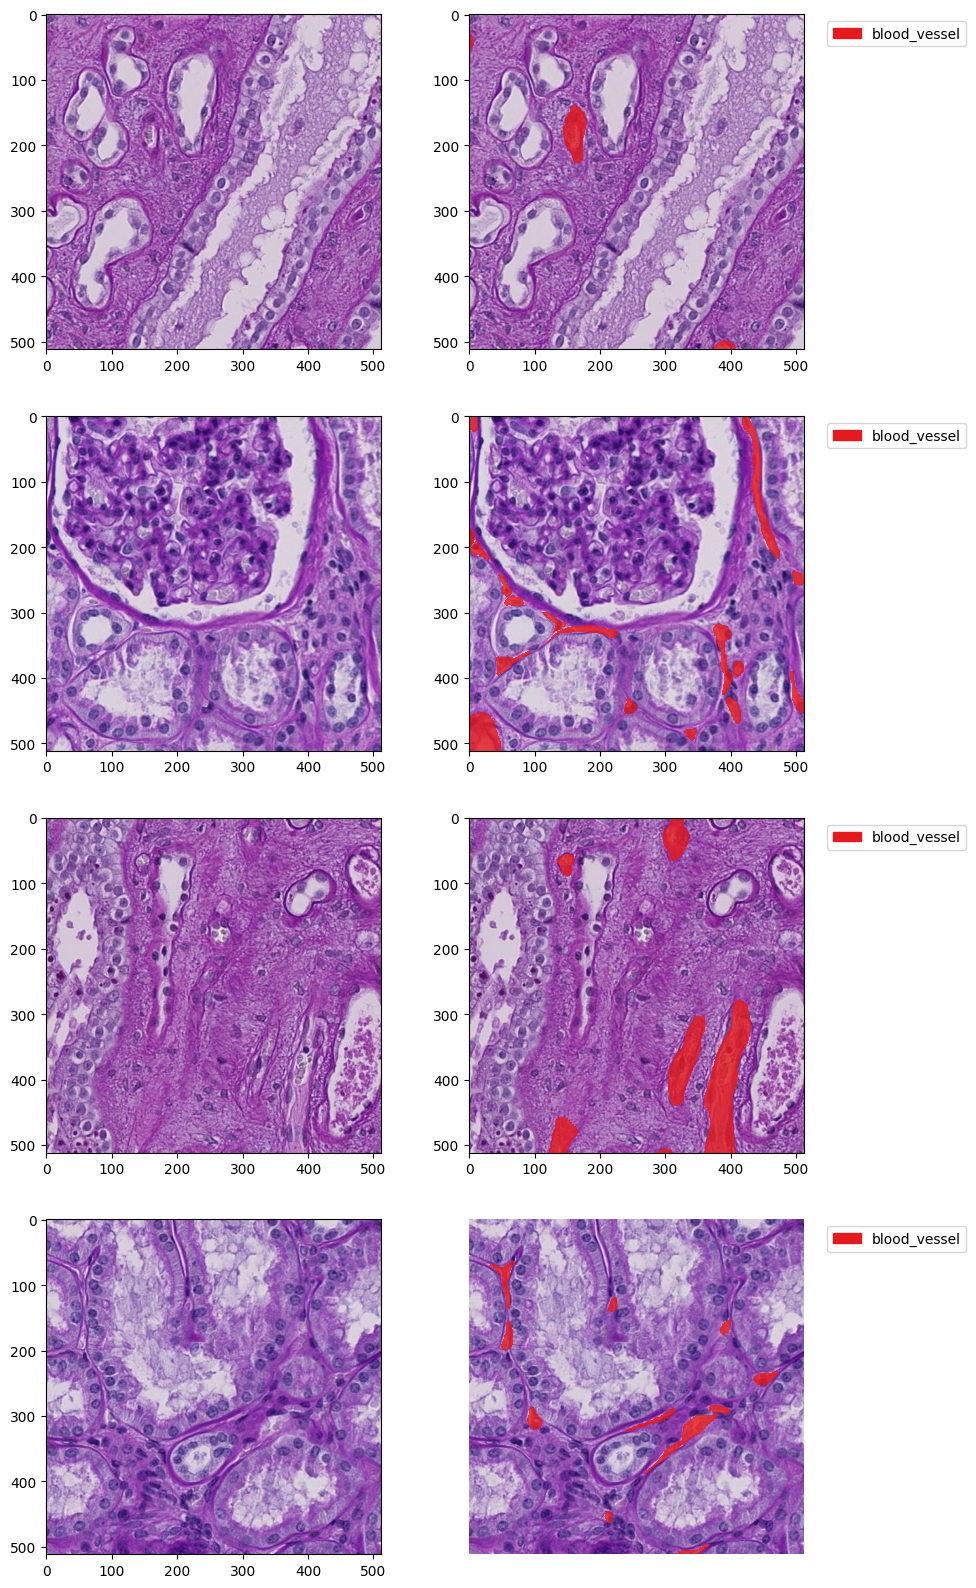

In [24]:
dataDir = Path("/home/nischay/hubmap/Data/train")
annFile = Path(f"coco/ds1_coco_1024_valid_all_fold{selected_fold}.json")

colors = ['Set1'] 
legend = ids_categories #{1: 'blood_vessel'}

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[0:4])

fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))
for img, ax_row in zip(imgs, axs):
    ax = ax_row[0]  # Access the first axis in each row
    I = io.imread(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    ax.imshow(I)
    ax = ax_row[1]  # Access the second axis in each row
    ax.imshow(I)
    plt.sca(ax)
    for i, ann in enumerate(anns):
        category_id = ann['category_id']
        color = colors[category_id-1]
        #-----------------------------------------
        mask = coco.annToMask(ann)
        mask = np.ma.masked_where(mask == 0, mask)
        ax.imshow(mask, cmap=color, alpha=0.8)
        #-----------------------------------------
        handles = []
        for category_id in legend:
            color = colors[category_id - 1]
            handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
        ax.legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

In [25]:
import torch
config = torch.load('config.pth')

In [26]:
import pprint


In [27]:
config_str = config['config']


In [28]:
exec(config_str)


In [29]:
# config_str

In [30]:
pprint.pprint(model)

{'backbone': {'conv_cfg': {'type': 'ConvAWS'},
              'depth': 50,
              'frozen_stages': 1,
              'norm_cfg': {'requires_grad': True, 'type': 'BN'},
              'norm_eval': True,
              'num_stages': 4,
              'out_indices': (0, 1, 2, 3),
              'output_img': True,
              'sac': {'type': 'SAC', 'use_deform': True},
              'stage_with_sac': (False, True, True, True),
              'style': 'pytorch',
              'type': 'DetectoRS_ResNet'},
 'neck': {'aspp_dilations': (1, 3, 6, 1),
          'aspp_out_channels': 64,
          'in_channels': [256, 512, 1024, 2048],
          'num_outs': 5,
          'out_channels': 256,
          'rfp_backbone': {'conv_cfg': {'type': 'ConvAWS'},
                           'depth': 50,
                           'frozen_stages': 1,
                           'norm_cfg': {'requires_grad': True, 'type': 'BN'},
                           'norm_eval': True,
                           'num_stages'

In [31]:
# pprint.pprint(config_str)

In [32]:
# pprint.pprint(img_scale)
# pprint.pprint(config_str)

In [33]:
# config

In [34]:
!wget https://download.openmmlab.com/mmdetection/v2.0/detectors/detectors_htc_r101_20e_coco/detectors_htc_r101_20e_coco_20210419_203638-348d533b.pth

--2023-07-02 17:52:25--  https://download.openmmlab.com/mmdetection/v2.0/detectors/detectors_htc_r101_20e_coco/detectors_htc_r101_20e_coco_20210419_203638-348d533b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.20.230, 47.246.20.229, 47.246.20.232, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.20.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 802513683 (765M) [application/octet-stream]
Saving to: ‘detectors_htc_r101_20e_coco_20210419_203638-348d533b.pth.1’

detectors_htc_r101_ 100%[===================>] 765.34M  7.71MB/s    in 1m 41s  

2023-07-02 17:54:07 (7.55 MB/s) - ‘detectors_htc_r101_20e_coco_20210419_203638-348d533b.pth.1’ saved [802513683/802513683]



In [35]:
import torch
m = torch.load('detectors_htc_r101_20e_coco_20210419_203638-348d533b.pth')

In [36]:
import pprint
pprint.pprint(m['meta']['config'])


("dataset_type = 'CocoDataset'\n"
 "data_root = 'data/coco/'\n"
 'img_norm_cfg = dict(\n'
 '    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], '
 'to_rgb=True)\n'
 'train_pipeline = [\n'
 "    dict(type='LoadImageFromFile'),\n"
 '    dict(\n'
 "        type='LoadAnnotations', with_bbox=True, with_mask=True, "
 'with_seg=True),\n'
 "    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),\n"
 "    dict(type='RandomFlip', flip_ratio=0.5),\n"
 '    dict(\n'
 "        type='Normalize',\n"
 '        mean=[123.675, 116.28, 103.53],\n'
 '        std=[58.395, 57.12, 57.375],\n'
 '        to_rgb=True),\n'
 "    dict(type='Pad', size_divisor=32),\n"
 "    dict(type='SegRescale', scale_factor=0.125),\n"
 "    dict(type='DefaultFormatBundle'),\n"
 '    dict(\n'
 "        type='Collect',\n"
 "        keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks', "
 "'gt_semantic_seg'])\n"
 ']\n'
 'test_pipeline = [\n'
 "    dict(type='LoadImageFromFile'),\n"
 '    dict(\n'
 "        type=